## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)

## Function

## Directory

In [4]:
adata_dir = '/nfs/team205/heart/anndata_objects/8regions'

## Read in data

* batch_key: donor + nuclei_or_cells + kit_10x

In [5]:
adata = sc.read_h5ad(f'{adata_dir}/scVI/multiome_RNA_adult_new-SAN-AVN_scVI.h5ad')
adata

AnnData object with n_obs × n_vars = 94964 × 4581
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'clus20', 'doublet_cls'
    var: 'gene_name', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi', 'cell_or_nuclei_colors', 'clus20_colors', 'donor_colors', 'doublet_cls_colors', 'hvg', 'kit_10x_colors', 'leiden', 'leiden_scVI_colors', 'neighbors', 'region_colors', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous

## Clustering, UMAP

In [6]:
%%time
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.tl.leiden(adata, resolution=2, key_added='leiden_scVI',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:02:48)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:02:56)
running Leiden clustering
    finished: found 48 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:01:02)


CPU times: user 5min 55s, sys: 1min 38s, total: 7min 33s
Wall time: 6min 47s


In [7]:
# check where the cluster 20 cells fall into
clus20_cells = list(pd.read_csv('clus20_index.csv')['barcode'])

adata.obs['clus20']='No'
clus20_cells = list(set(clus20_cells).intersection(adata.obs_names))
adata.obs.loc[clus20_cells,'clus20']='Yes'
sum(adata.obs['clus20']=='Yes')

161

... storing 'clus20' as categorical


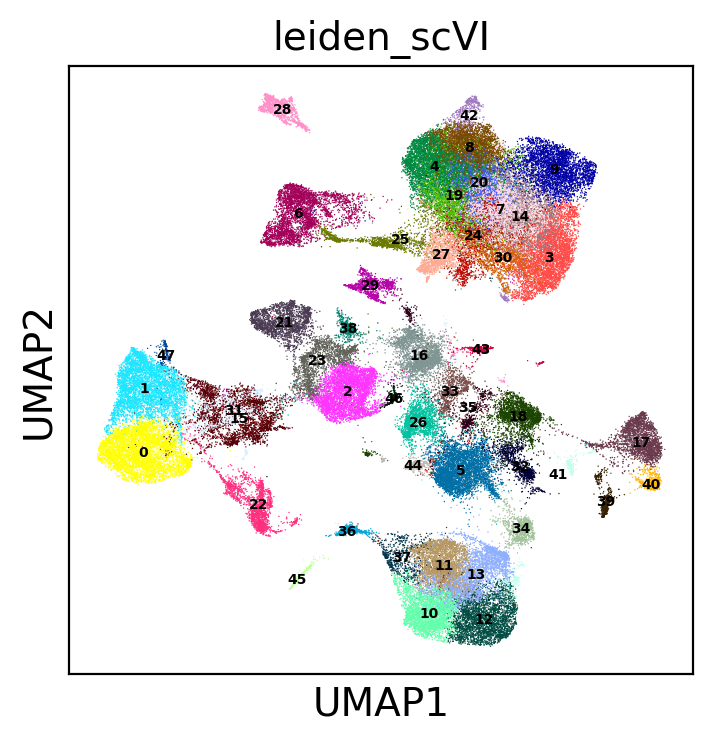

In [8]:
sc.pl.umap(adata, color=['leiden_scVI',], size=1, legend_loc='on data', legend_fontsize=5)

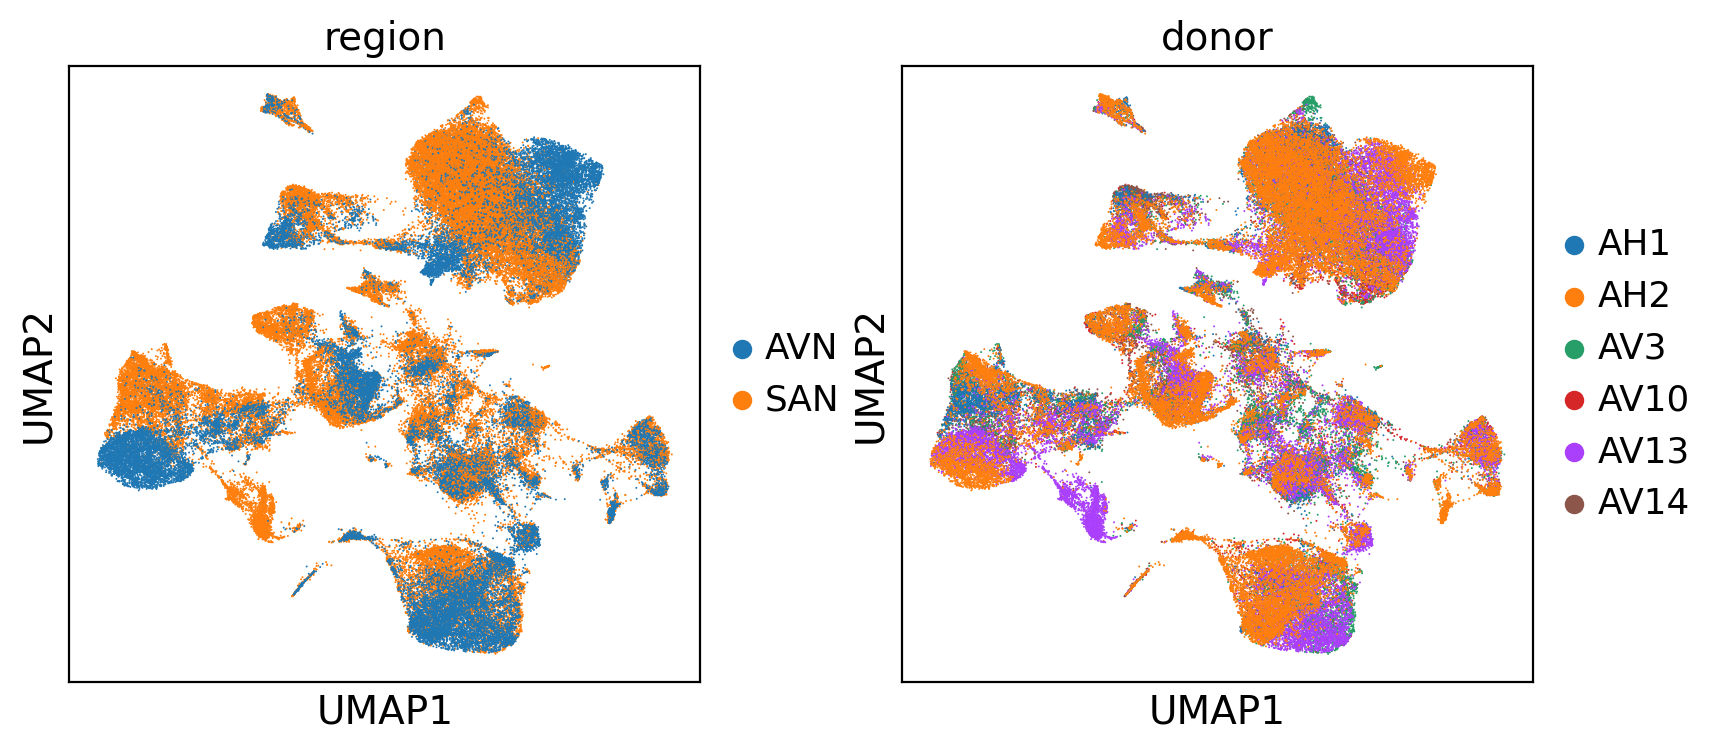

In [9]:
sc.pl.umap(adata, color=['region','donor'], size=2, wspace=0.2)

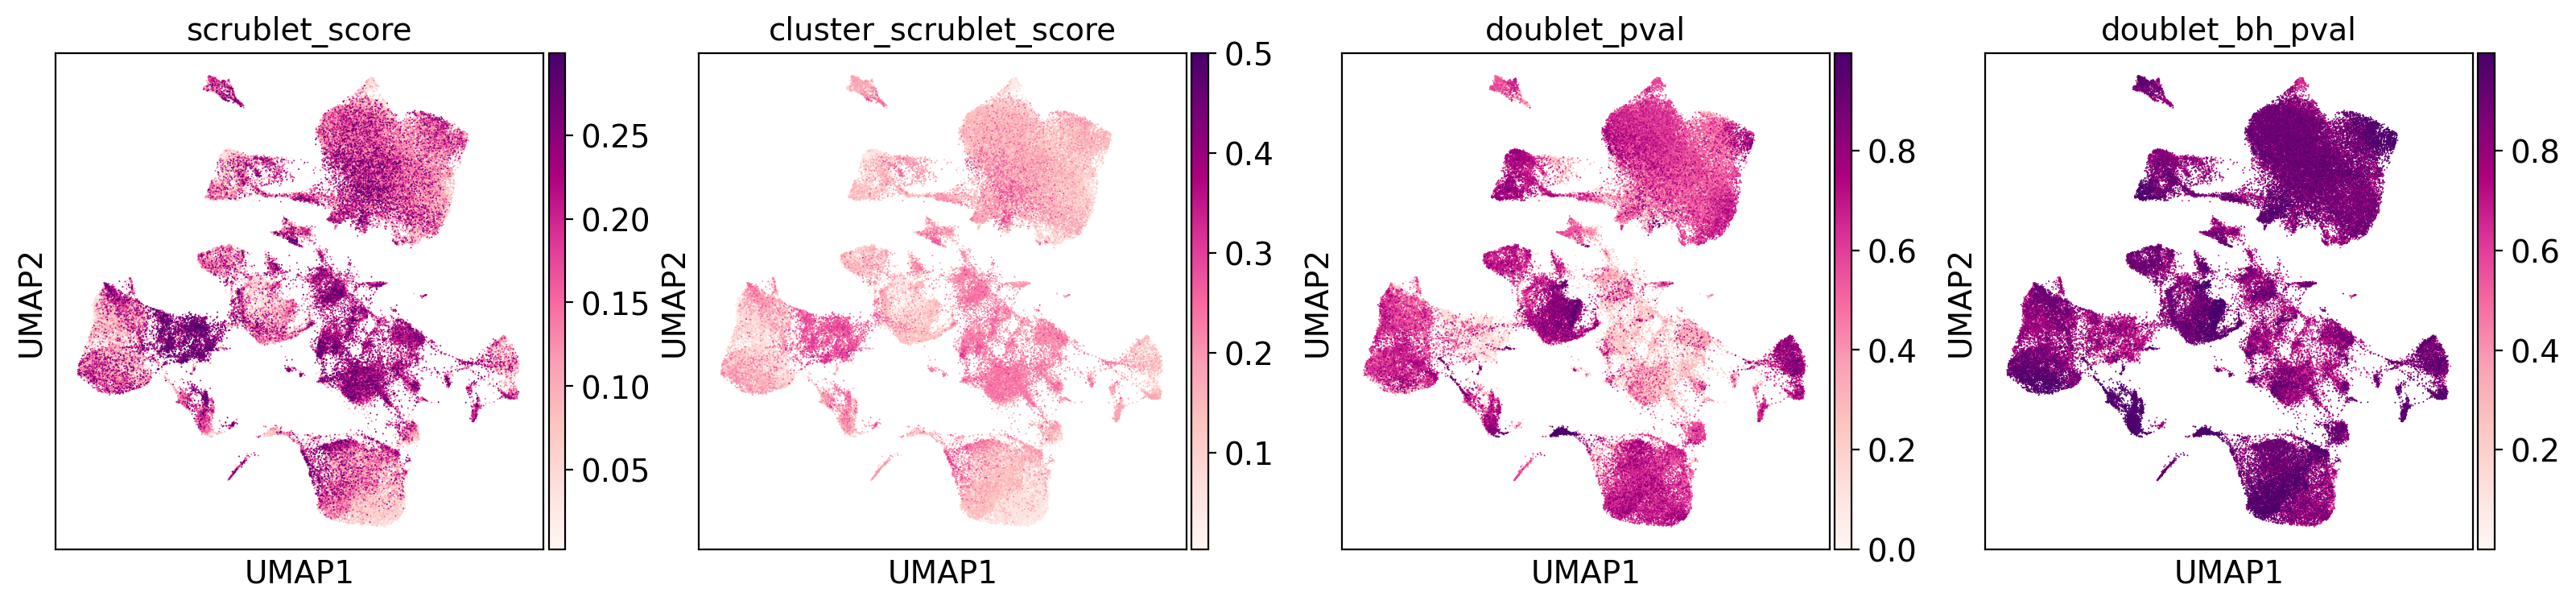

In [10]:
sc.pl.umap(adata, use_raw=True, color=['scrublet_score','cluster_scrublet_score','doublet_pval','doublet_bh_pval'], size=2, wspace=0.2, ncols=5)

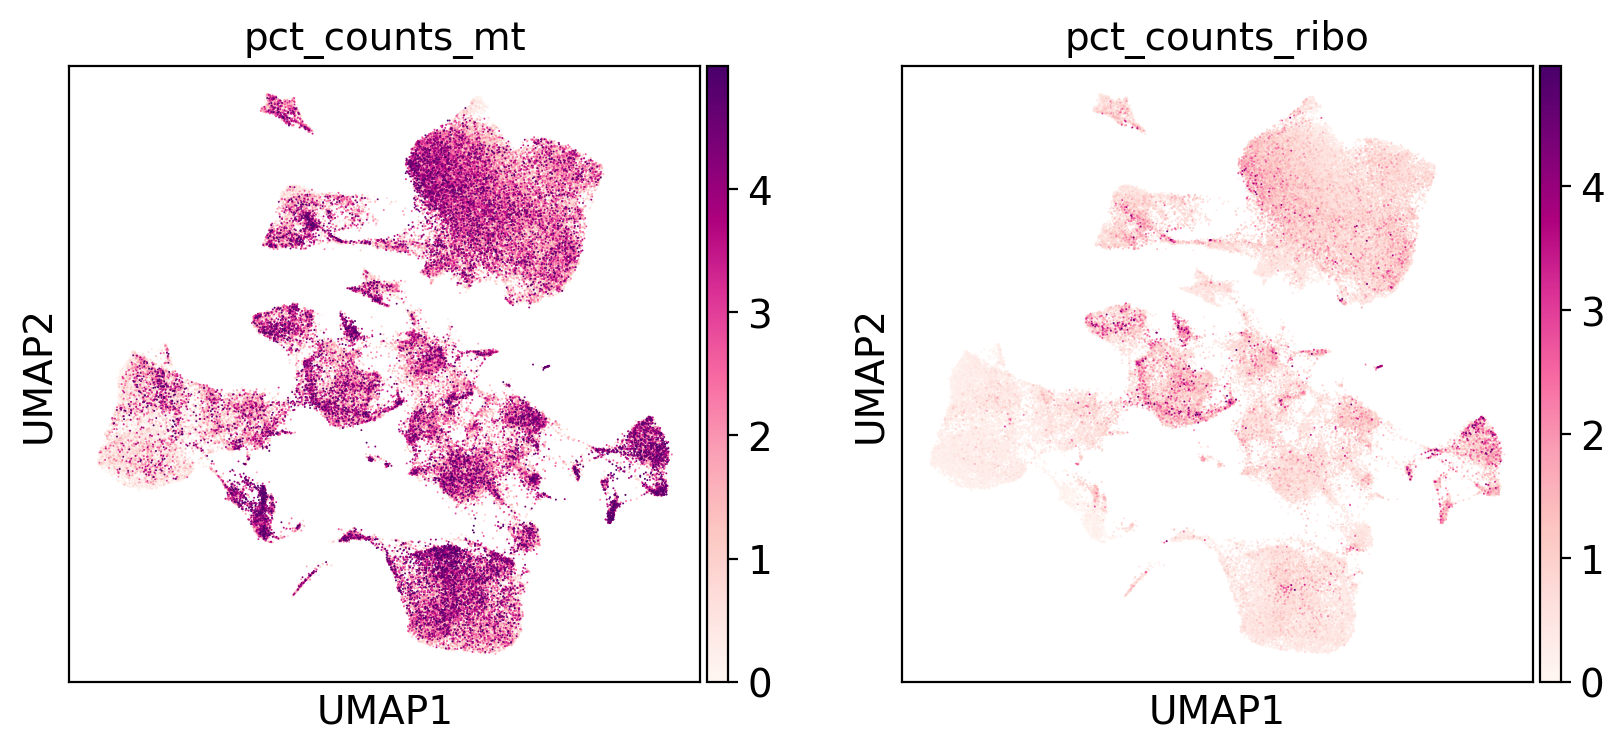

In [11]:
sc.pl.umap(adata, use_raw=True, color=['pct_counts_mt','pct_counts_ribo'], size=2, wspace=0.2, ncols=5)

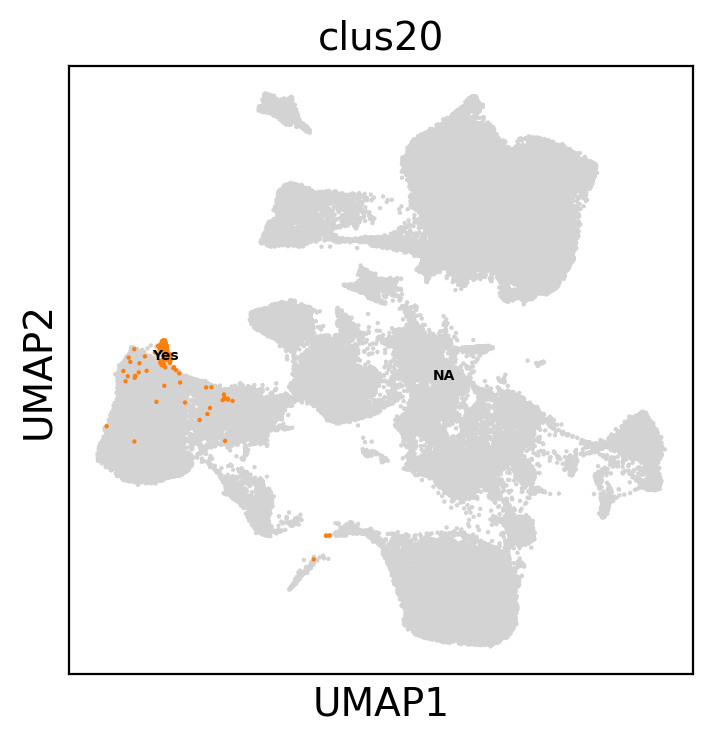

In [12]:
sc.pl.umap(adata, color=['clus20',], groups='Yes', size=10, legend_loc='on data', legend_fontsize=5)

## Annotate doublet-like clusters

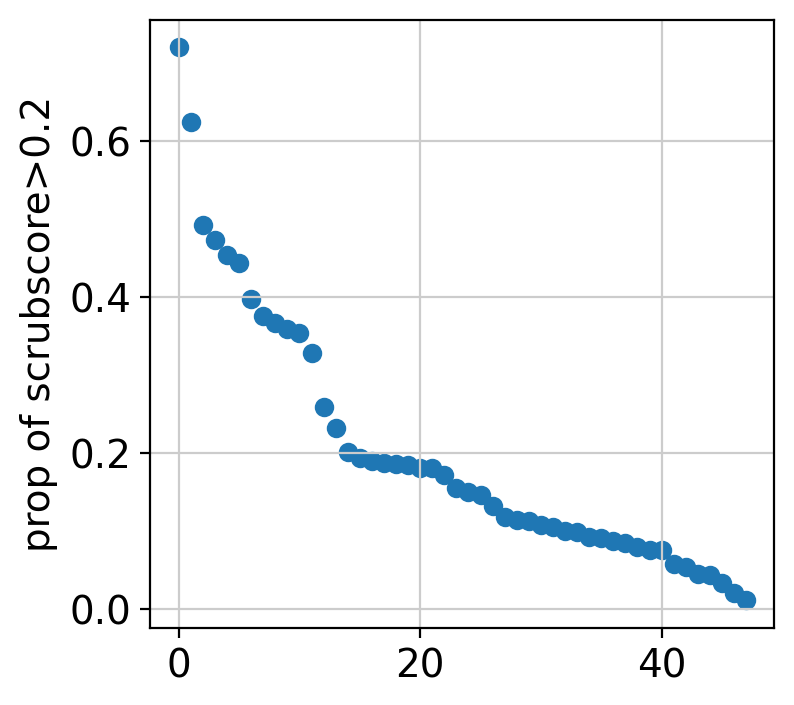

In [13]:
# proportion of scrublet score > 0.2 per cluster
df=pd.crosstab(adata.obs['scrublet_score']>0.2,adata.obs['leiden_scVI']).T.copy()
df=df.apply(lambda x:x[True]/np.sum(x), axis=1)
df=df.sort_values(ascending=False)
df=pd.DataFrame(df)
# df.rename(columns={0:'prop of scrubscore>0.2'}).head(n=20)
plt.scatter(x=range(len(df)), y=df[0])
plt.ylabel('prop of scrubscore>0.2')
plt.show()

In [14]:
# proportion of scrublet score > 0.2 per cluster
df=pd.crosstab(adata.obs['scrublet_score']>0.2,adata.obs['leiden_scVI']).T.copy()
df=df.apply(lambda x:x[True]/np.sum(x), axis=1)
df=df.sort_values(ascending=False)
df=pd.DataFrame(df)
df=df.rename(columns={0:'prop of scrubscore>0.2'})

# get clusters which have more than 30% of scrublet score > 0.2 data point -> Doublet clusters
doublet_cls = list(df.index[df['prop of scrubscore>0.2']>0.3])
print(f'doublet clusters: {doublet_cls}')

df.head(n=15)

doublet clusters: ['15', '31', '26', '33', '44', '5', '16', '35', '32', '37', '18', '24']


prop of scrubscore>0.2
leiden_scVI                        
15                         0.721071
31                         0.625479
26                         0.492188
33                         0.473797
44                         0.454829
5                          0.444308
16                         0.397705
35                         0.375566
32                         0.366502
37                         0.359223
18                         0.353642
24                         0.328492
43                         0.258486
38                         0.231618
29                         0.201395

In [15]:
# proportion of the doublet cluster cell number
np.sum(adata.obs['leiden_scVI'].isin(doublet_cls))/len(adata)

0.20754180531569857

In [16]:
# annotate doublet clusters
adata.obs['doublet_cls']='No'
doublet_b=adata.obs[adata.obs['leiden_scVI'].isin(doublet_cls)].index
adata.obs.loc[doublet_b,'doublet_cls']='Yes'
adata.obs['doublet_cls'].value_counts()

No     75255
Yes    19709
Name: doublet_cls, dtype: int64

... storing 'doublet_cls' as categorical


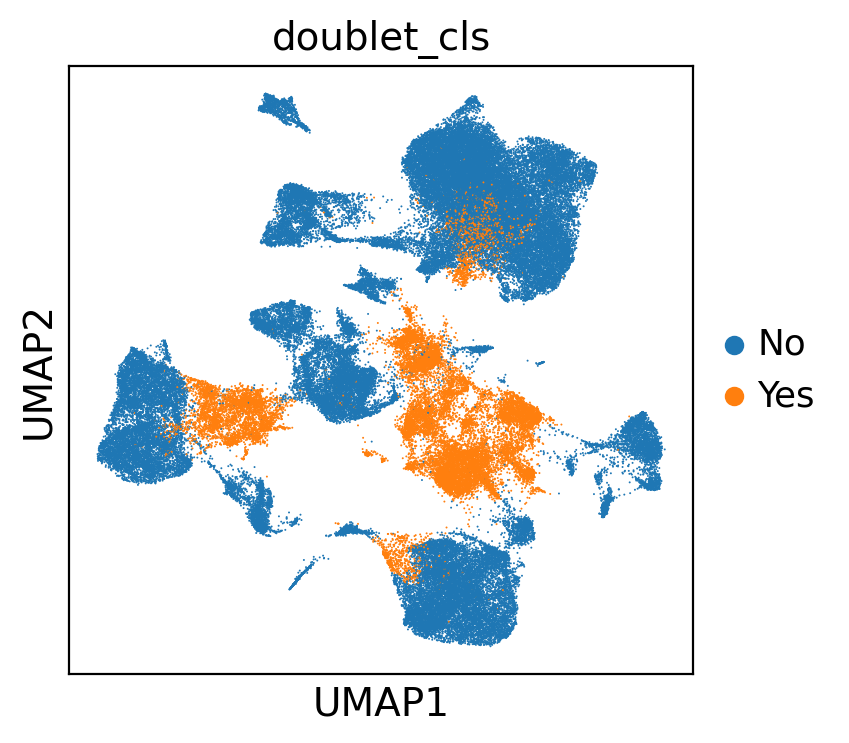

In [17]:
sc.pl.umap(adata, use_raw=True, color=['doublet_cls'], size=2, wspace=0.2, ncols=5)

In [18]:
adata.write(f'{adata_dir}/scVI/multiome_RNA_adult_new-SAN-AVN_scVI.h5ad')

## Remove doublet-clusters and save

In [19]:
# remove
adata2 = adata[adata.obs['doublet_cls']=='No']

In [20]:
# reconstruct
adata_raw=sc.read_h5ad(f'{adata_dir}/QC/multiome_RNA_adult_new-SAN-AVN.h5ad')
print(adata_raw.shape)

import anndata
adata_raw=anndata.AnnData(X=adata_raw[adata2.obs_names,:].X,
                      obs=adata2.obs, # from post-scVI data
                      var=adata_raw.var,
                      obsm=adata2.obsm, # from post-scVI data
                               )
adata_raw

(94964, 36601)


AnnData object with n_obs × n_vars = 75255 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'batch_key', '_scvi_batch', '_scvi_labels', 'leiden_scVI', 'clus20', 'doublet_cls'
    var: 'gene_name', 'feature_type', 'ambient_expression-0', 'ambient_expression-1', 'ambient_expression-10', 'ambient_expression-11', 'ambient_expression-12', 'ambient_expression-13', 'ambient_expression-14', 'ambient_expression-15', 'ambient_expression-16', 'ambient_expression-2', 'ambient_expression-3', 'ambient_expression-4', 'ambient_expression-5', 'ambient_expression-6', 'ambient_expressio

In [21]:
# save
adata_raw.write(f'{adata_dir}/multiome_RNA_adult_new-SAN-AVN_raw_rmdblcls.h5ad')

In [22]:
adata_raw.X.data[:10]

array([2., 1., 4., 2., 4., 1., 4., 2., 1., 1.], dtype=float32)

In [23]:
adata_dir

'/nfs/team205/heart/anndata_objects/8regions'